# Bike Sharing Demand - Huizhe Wang

# Part 1 -  Background
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

* license: Background comes form kaggle website. https://www.kaggle.com/c/bike-sharing-demand

#  Part 2 -  Evaluation: 
## RMSLE (Root Mean Squared Logarithmic Error)

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as
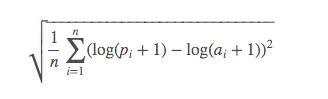
Where:
```
n is the number of hours in the test set
pi is your predicted count
ai is the actual count
log(x) is the natural logarithm
```
* License: RMSLE comes form kaggle website. https://www.kaggle.com/c/bike-sharing-demand#evaluation


# Part 3 - Load and Prepare Datasets
## 1. Data Introduction 
```
datetime - hourly date + timestamp
season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
```
We can see the riders separate into casual riders and registered riders, and the value of count is the total number of the two kinds of riders.

In [1]:
## import Libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import sys
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv("data/train.csv")
df_train['dataset'] = 'train'

df_test = pd.read_csv("data/test.csv")
df_test['dataset'] = 'test'

In [3]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dataset
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


## 2. Data Cleaning 

**Converting datetime column fron str to DatetimeIndex**

In [4]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).day

df_train['DOW'] = pd.DatetimeIndex(df_train.datetime).dayofweek 
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
df_train['year'] = pd.DatetimeIndex(df_train.datetime).year

df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).day
df_test['DOW'] = pd.DatetimeIndex(df_test.datetime).dayofweek 
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year

In [5]:
dt = pd.DatetimeIndex(df_train['datetime'])
df_train.set_index(dt, inplace=True)
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dataset,month,day,DOW,hour,year
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train,1,1,5,0,2011
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train,1,1,5,1,2011
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train,1,1,5,2,2011
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train,1,1,5,3,2011
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train,1,1,5,4,2011


In [6]:
dt = pd.DatetimeIndex(df_test['datetime'])
df_test.set_index(dt, inplace=True)
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,dataset,month,day,DOW,hour,year
2011-01-20 00:00:00,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,test,1,20,3,0,2011
2011-01-20 01:00:00,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,test,1,20,3,1,2011
2011-01-20 02:00:00,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,test,1,20,3,2,2011
2011-01-20 03:00:00,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,test,1,20,3,3,2011
2011-01-20 04:00:00,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,test,1,20,3,4,2011


**Cleaning workingday and holiday varibles**

The code in the document by Github ST7oo is licensed under the MIT License:
https://opensource.org/licenses/MIT

In [7]:
#set workingday and holiday
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

#for working day
# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0

# for holiday
# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0
# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1
#storms
df_test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#tornado
df_train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [8]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dataset,month,day,DOW,hour,year
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train,1,1,5,0,2011
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train,1,1,5,1,2011
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train,1,1,5,2,2011
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train,1,1,5,3,2011
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train,1,1,5,4,2011


In [9]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,DOW,hour,year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.026364,0.685284,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,6.521495,9.992559,3.013963,11.541613,2011.501929
std,1.116174,0.160223,0.464424,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,3.444373,5.476608,2.004585,6.915838,0.500019
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2011.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,4.000000,5.000000,1.000000,6.000000,2011.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,7.000000,10.000000,3.000000,12.000000,2012.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,10.000000,15.000000,5.000000,18.000000,2012.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,12.000000,19.000000,6.000000,23.000000,2012.000000


**Combine train dataset and test dataset into one dataset**

In [10]:
# combine train and test data into one df
df = df_train.append(df_test)
# set datetime as index and drop depulicate column
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
df = df.drop('datetime', axis=1)
# order data by datetime
drange = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df = df.reindex(drange)
# order column by train data's order
df = df[df_train.drop(['datetime'],axis=1).columns]
df= df.drop('DOW', axis=1)
df['DOW'] = pd.DatetimeIndex(df.index).dayofweek 
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    df['%s_log' % col] = np.log(df[col] + 1)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dataset,month,day,hour,year,DOW,casual_log,registered_log,count_log
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,3.0,13.0,16.0,train,1.0,1.0,0.0,2011.0,5,1.386294,2.639057,2.833213
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,40.0,train,1.0,1.0,1.0,2011.0,5,2.197225,3.496508,3.713572
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,32.0,train,1.0,1.0,2.0,2011.0,5,1.791759,3.332205,3.496508
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,13.0,train,1.0,1.0,3.0,2011.0,5,1.386294,2.397895,2.639057
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,0.0,1.0,1.0,train,1.0,1.0,4.0,2011.0,5,0.000000,0.693147,0.693147


**Round Data**

In [11]:
# round data
df["weather"] = df["weather"].interpolate(method='time').apply(np.round)
df["temp"] = df["temp"].interpolate(method='time')
df["atemp"] = df["atemp"].interpolate(method='time')
df["humidity"] = df["humidity"].interpolate(method='time').apply(np.round)
df["windspeed"] = df["windspeed"].interpolate(method='time')

df["season"] = df["season"].interpolate(method='time').apply(np.round)
df["holiday"] = df["holiday"].interpolate(method='time').apply(np.round)
df["workingday"] = df["workingday"].interpolate(method='time').apply(np.round)

df["month"] = df["month"].interpolate(method='time').apply(np.round)
df["day"] = df["day"].interpolate(method='time').apply(np.round)
df["hour"] = df["hour"].interpolate(method='time').apply(np.round)
df["year"] = df["year"].interpolate(method='time').apply(np.round)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dataset,month,day,hour,year,DOW,casual_log,registered_log,count_log
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,3.0,13.0,16.0,train,1.0,1.0,0.0,2011.0,5,1.386294,2.639057,2.833213
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,40.0,train,1.0,1.0,1.0,2011.0,5,2.197225,3.496508,3.713572
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,32.0,train,1.0,1.0,2.0,2011.0,5,1.791759,3.332205,3.496508
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,13.0,train,1.0,1.0,3.0,2011.0,5,1.386294,2.397895,2.639057
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,0.0,1.0,1.0,train,1.0,1.0,4.0,2011.0,5,0.000000,0.693147,0.693147


## 3. Data Exploration

## 3.1 Analysis basic features

**The relationship between count of rentals and the season features**

In [12]:
# add a count_season column using join
by_season = df_train.groupby('season')[['count']].agg(sum)
by_season.columns = ['count_season']
df = df.join(by_season, on='season')

by_season

,count_season
season,
1,312498
2,588282
3,640662
4,544034


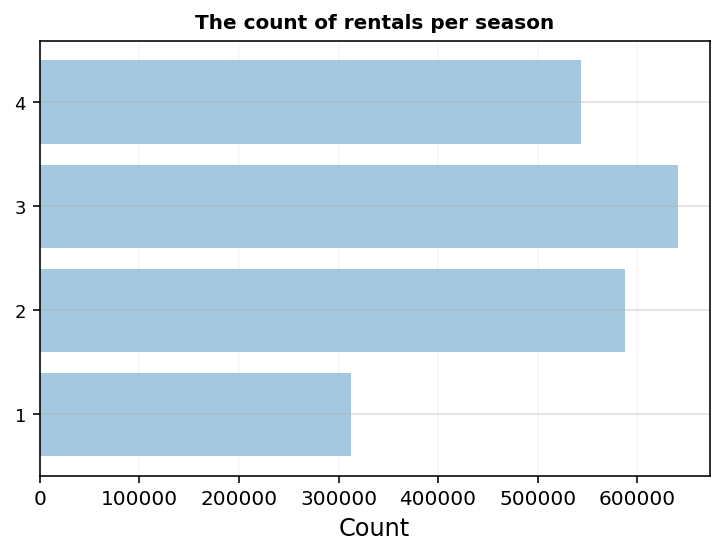

In [13]:
xticks = list(by_season.index)

#plotting
plt.barh([x for x in range(len(xticks))], list(by_season['count_season']), align='center', alpha=0.4)
plt.yticks([x for x in range(len(xticks))], xticks, fontsize=9)

plt.xlabel("Count", fontsize=12)
plt.title("The count of rentals per season", fontsize=10, fontweight='bold')
plt.gca().xaxis.grid(True,linestyle='-',alpha=0.1)
plt.gca().yaxis.grid(True,alpha=0.4)

**Result Analysis**:

As dataset introduction said, season - 1 = spring, 2 = summer, 3 = fall, 4 = winter; we can see people prefer to use bike sharing systems in summer and fall. 

We predict the reason is the weather feature, there are least rental in spring beacause the spring is cold  Washington, D.C. 

**The relationship between count of rentals and the weather features**

In [14]:
# rentals by hour, split by working day (or not)
by_weather = df_train.copy().groupby('weather')[['count']].agg(sum)
by_weather.columns = ['count_weather']
df = df.join(by_weather, on='weather')
by_weather

,count_weather
weather,
1,1476063
2,507160
3,102089
4,164


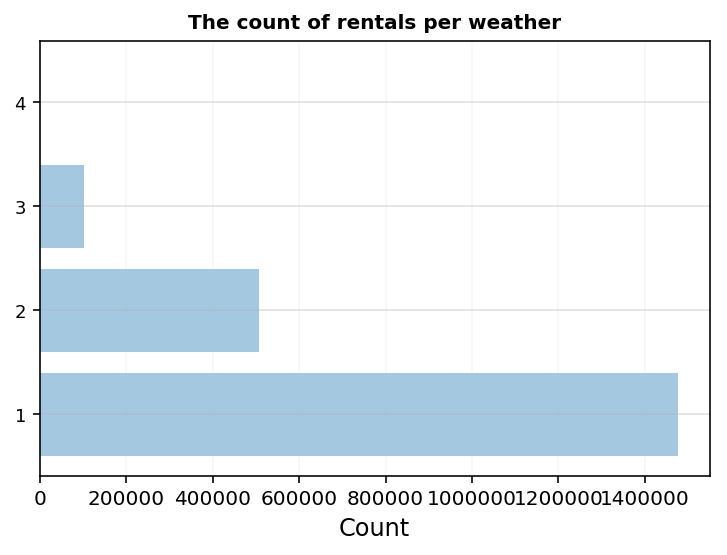

In [15]:
xticks = list(by_weather.index)

#plotting
plt.barh([x for x in range(len(xticks))], list(by_weather['count_weather']), align='center', alpha=0.4)
plt.yticks([x for x in range(len(xticks))], xticks, fontsize=9)

plt.xlabel("Count", fontsize=12)
plt.title("The count of rentals per weather", fontsize=10, fontweight='bold')
plt.gca().xaxis.grid(True,linestyle='-',alpha=0.1)
plt.gca().yaxis.grid(True,alpha=0.4)

**Result Analysis**:

As dataset introduction said, 
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

We predict the weather feature has very important influence of count.

**The relationship between count of rentals and the hour and working day (or not) features**

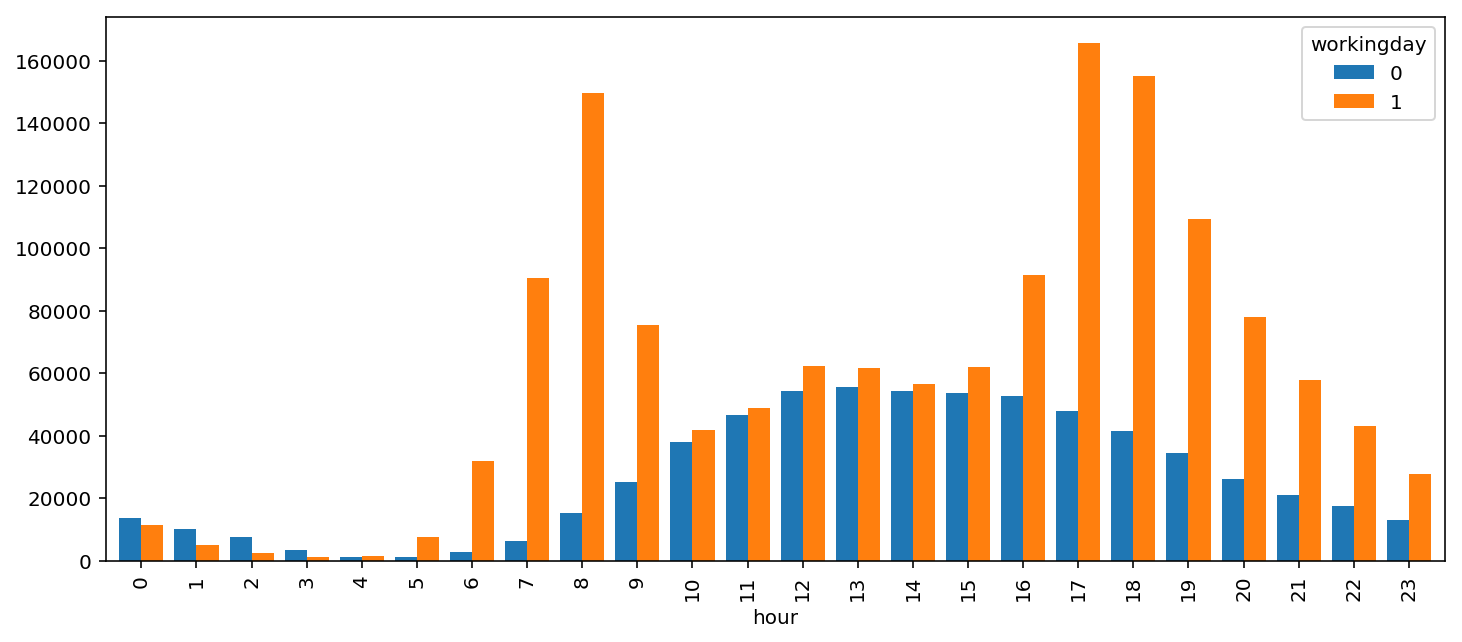

In [16]:
# rentals by hour, split by working day (or not)
by_hour = df_train.copy().groupby(['hour', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(12,5), width=0.8);

**Result Analysis**:

1. riders prefer to using bike sharing systems on working day. 

2. On working day, the peak of using bike sharing systems are 5:00 - 6:00 am and 4:00 - 8:00 pm, beacause they are the rush hour.

3. On weekend day, the peak of using bike sharing systems are 11:00 am - 5:00 pm.  

**The relationship between count of rentals and the temp and working day (or not) features**

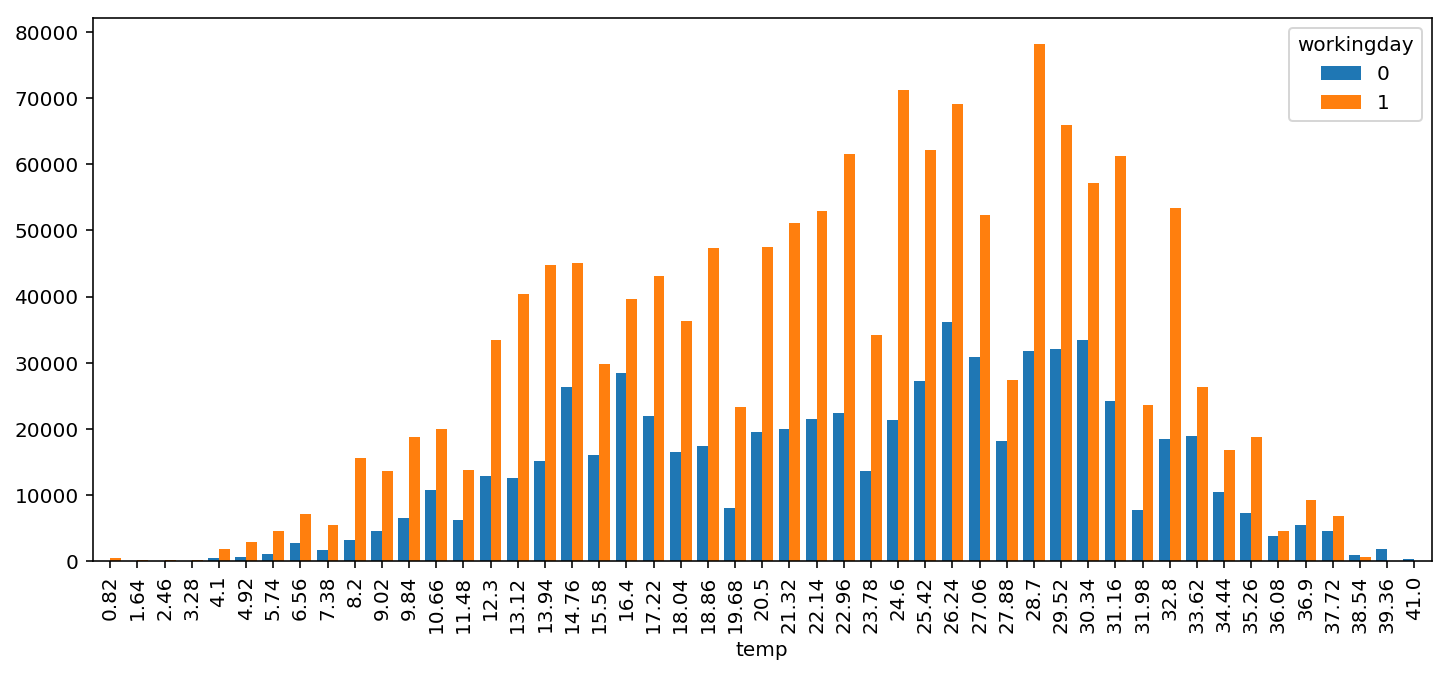

In [17]:
# rentals by temp, split by working day (or not)
by_hour = df_train.copy().groupby(['temp', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(12,5), width=0.8);

**Result Analysis:**

No matter on the workingday or weekend, if the value of temp is between 28 Celsius and 31 Celsius, users prefer to use bike sharing system.

**The relationship between count of rentals and the windspeed and working day (or not) features**

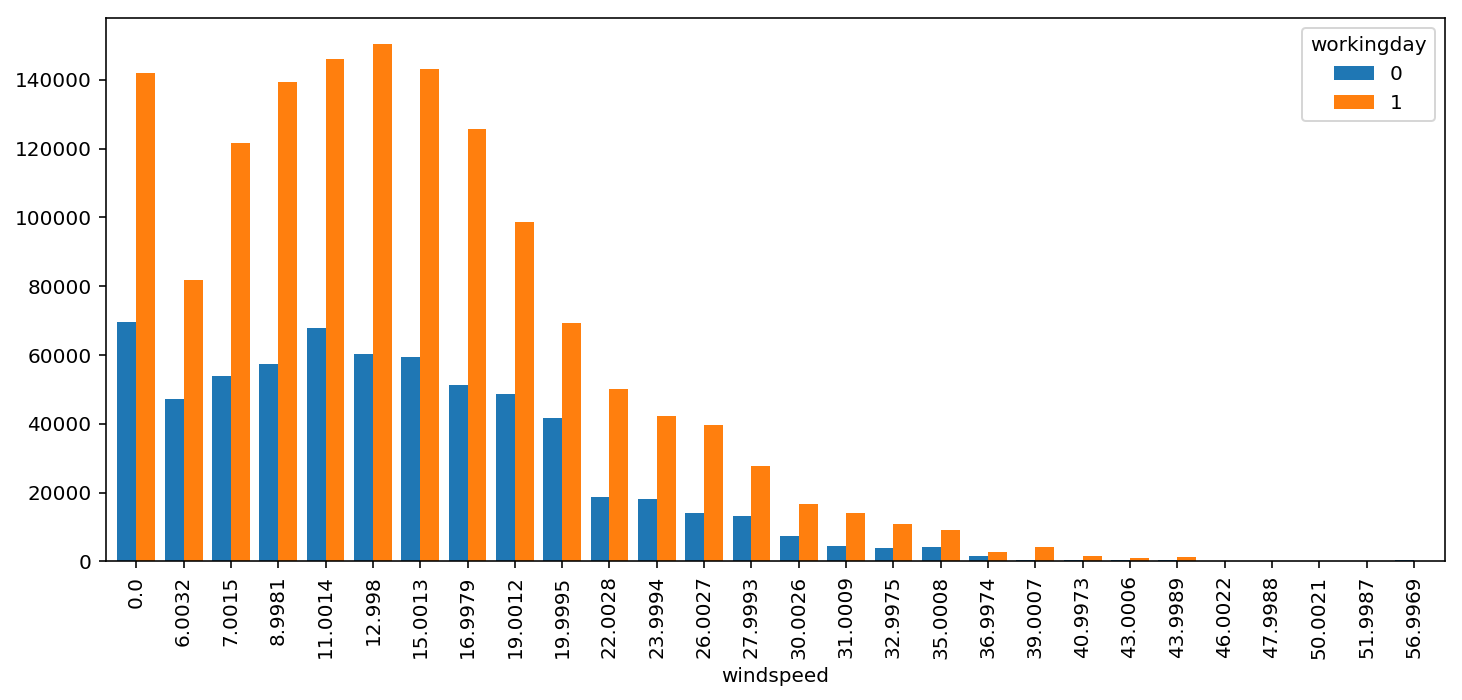

In [18]:
# rentals by windspeed, split by working day (or not)
by_hour = df_train.copy().groupby(['windspeed', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(12,5), width=0.8);

**Result Analysis:**

No matter on the workingday or weekend, if the value of windspeed < 20, users prefer to use bike sharing system.

**The relationship between count of rentals and the humidity and working day (or not) features**

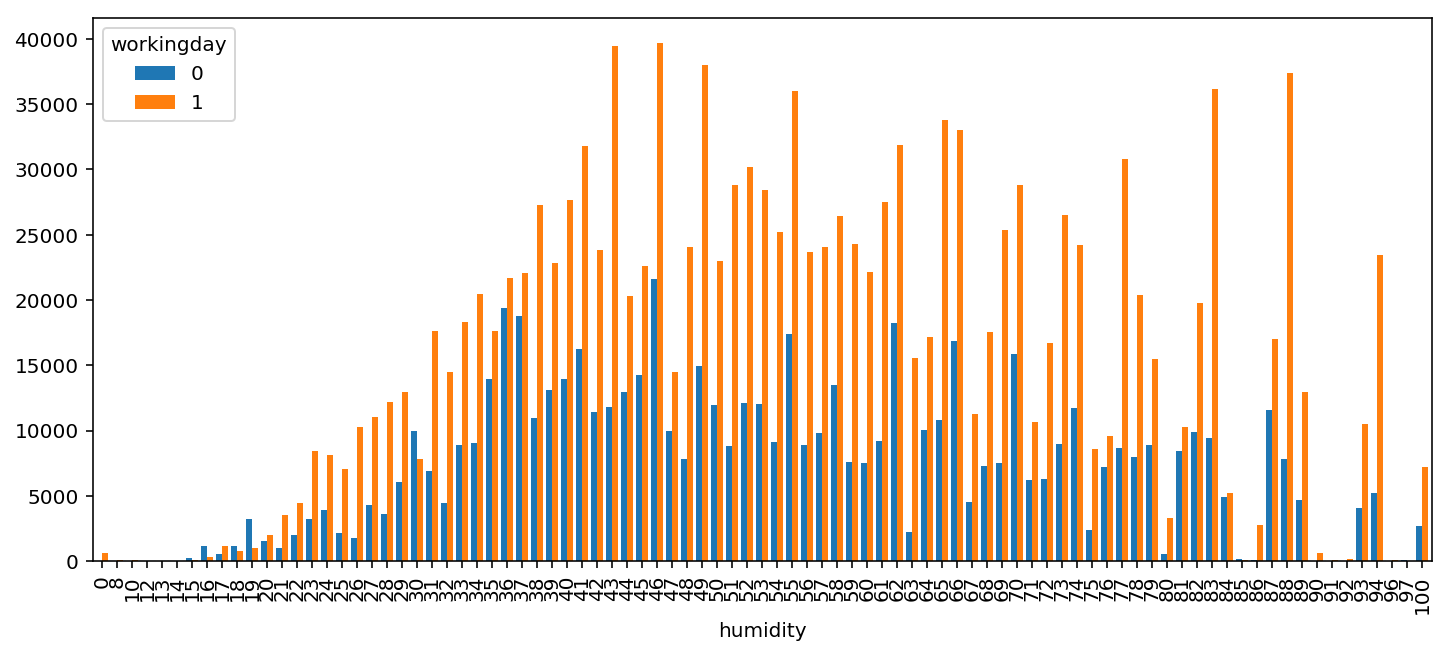

In [19]:
# rentals by humidity, split by working day (or not)
by_hour = df_train.copy().groupby(['humidity', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(12,5), width=0.8);

**Result Analysis:**

if the value of 43< humidity < 60, users prefer to use bike sharing system.

## 3.2 Create additional features

**create rush hour**

choose the basic features `hour` and `workingday` to create a new feature. As mentioned above, when on the workingday, if at 8:00 or at 12:00 or between 17:00 - 18:00, set the new feature `peak` as 1, otherwise set it as 0. Moreover, when on the weekend, if between 11:00 - 17:00, set the new feature `peak` as 1, otherwise set it as 0.

In [20]:
df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  11 <= x['hour'] <= 17)], axis = 1)
df_train['peak'] = df_train[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  11 <= x['hour'] <= 17)], axis = 1)
df_test['peak'] = df_test[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  11 <= x['hour'] <= 17)], axis = 1)

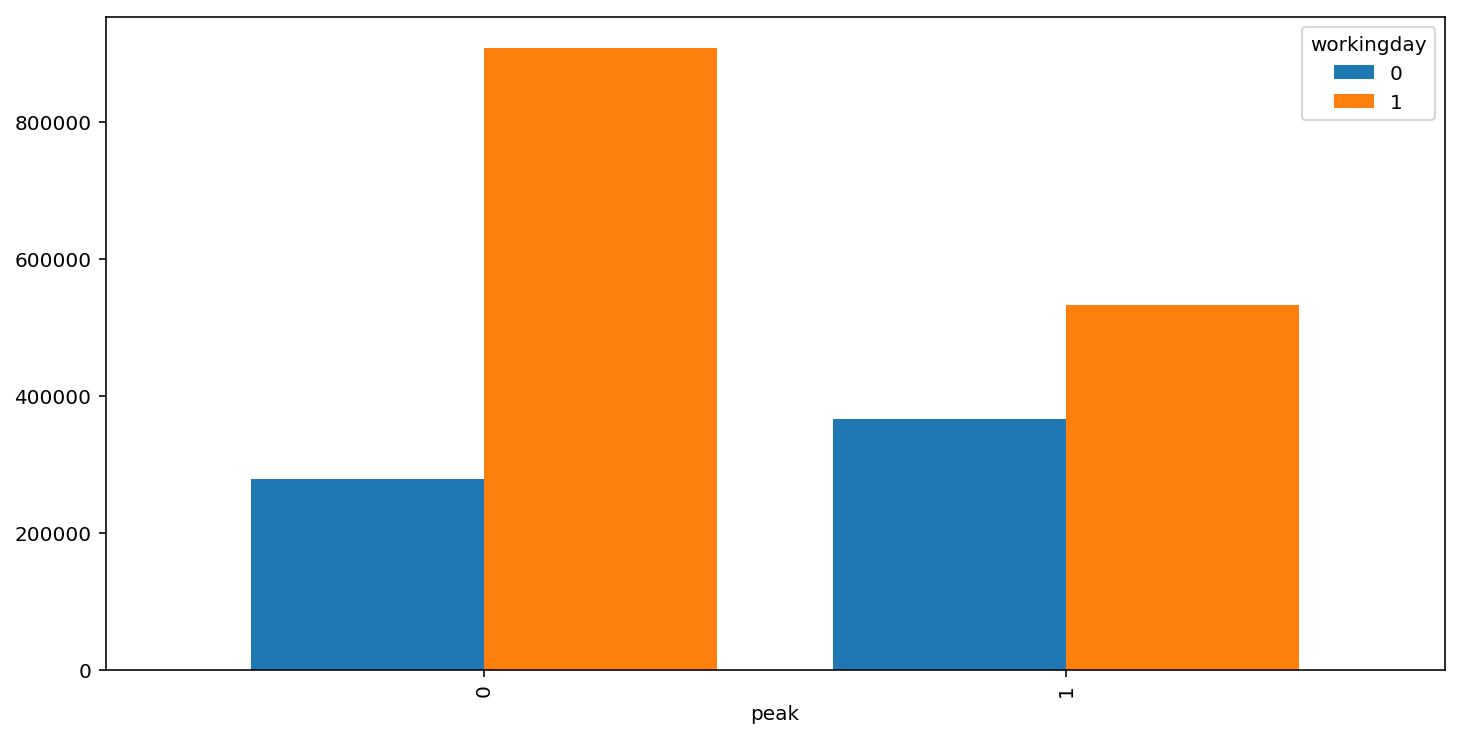

In [61]:
# rentals by peak, split by working day (or not)
by_hour = df_train.copy().groupby(['peak', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(12,6), width=0.8);

**create ideal environment**

choose the basic features `temp` and `windspeed` to create a new feature. As mentioned above, when on the workingday, if the value of temp between 28 Celsius and 31 Celsius and windspeed less than 20, set the new feature ideal as 1, otherwise set it as 0.

In [21]:
df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 28 and x['temp'] < 31 and x['windspeed'] < 20], axis = 1)
df_train['ideal'] = df_train[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 28 and x['temp'] < 20 and x['windspeed'] < 19], axis = 1)
df_test['ideal'] = df_test[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 28 and x['temp'] < 31 and x['windspeed'] < 20], axis = 1)

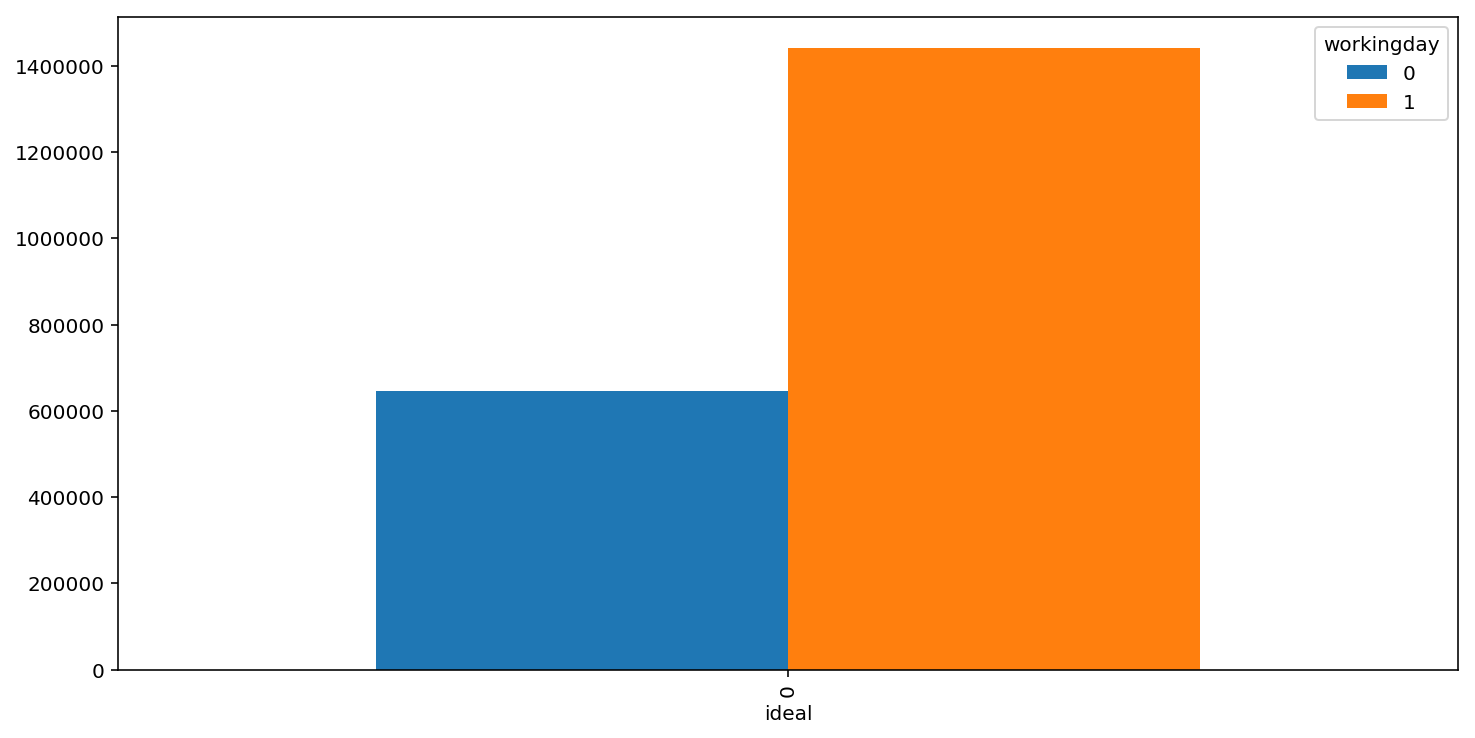

In [63]:
# rentals by ideal, split by working day (or not)
by_hour = df_train.copy().groupby(['ideal', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(12,6), width=0.8);

**create sticky humidity**

choose the basic features humidity and workingday to create a new feature. As mentioned above, when on the workingday, if the value of humidity stickier than 60, set the new feature ideal as 1, otherwise set it as 0.

In [22]:
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
df_train['sticky'] = df_train[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
df_test['sticky'] = df_test[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

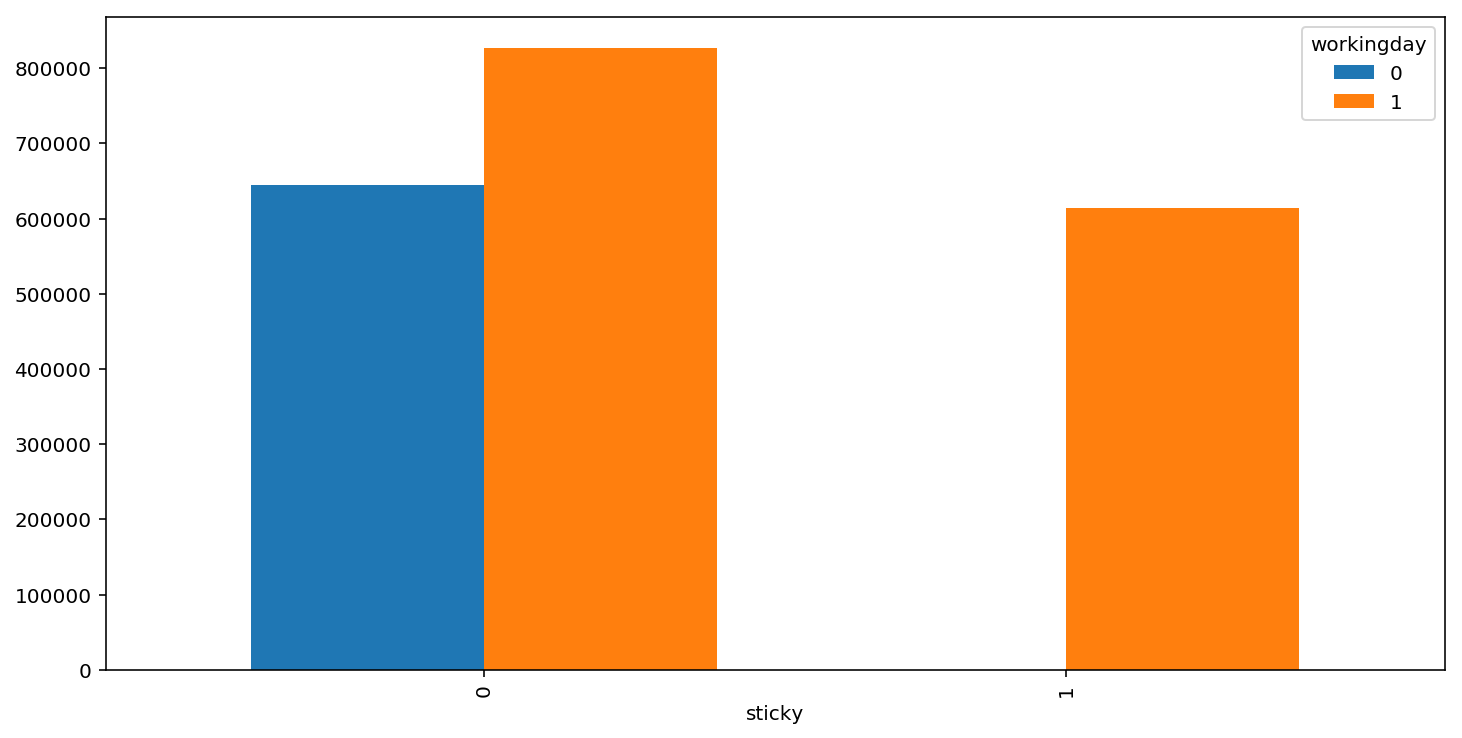

In [64]:
# rentals by sticky, split by working day (or not)
by_hour = df_train.copy().groupby(['sticky', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(12,6), width=0.8);

In [23]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,year,DOW,casual_log,registered_log,count_log,count_season,count_weather,peak,ideal,sticky
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,3.0,13.0,...,2011.0,5,1.386294,2.639057,2.833213,312498,1476063,0,0,0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,...,2011.0,5,2.197225,3.496508,3.713572,312498,1476063,0,0,0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,...,2011.0,5,1.791759,3.332205,3.496508,312498,1476063,0,0,0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,...,2011.0,5,1.386294,2.397895,2.639057,312498,1476063,0,0,0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,0.0,1.0,...,2011.0,5,0.000000,0.693147,0.693147,312498,1476063,0,0,0


# Part 4 Build Model 
**In this part, I build 3 models - random forest regression model, gradient boosting regressor model , and LSTM (RNN).**

Here I used two regression for ensemble model - RandomForestRegressor and GradientBoostingRegressor - can be import the packages from one library sklearn.ensemble.

LSTM is based on neural network, the first thing need to do is scaling data, and I used the neural network library Keras for LSTM, build a new model.

##  Random forest regression model

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.
 * The document is licensed by wiki: https://en.wikipedia.org/wiki/Wikipedia:Copyrights

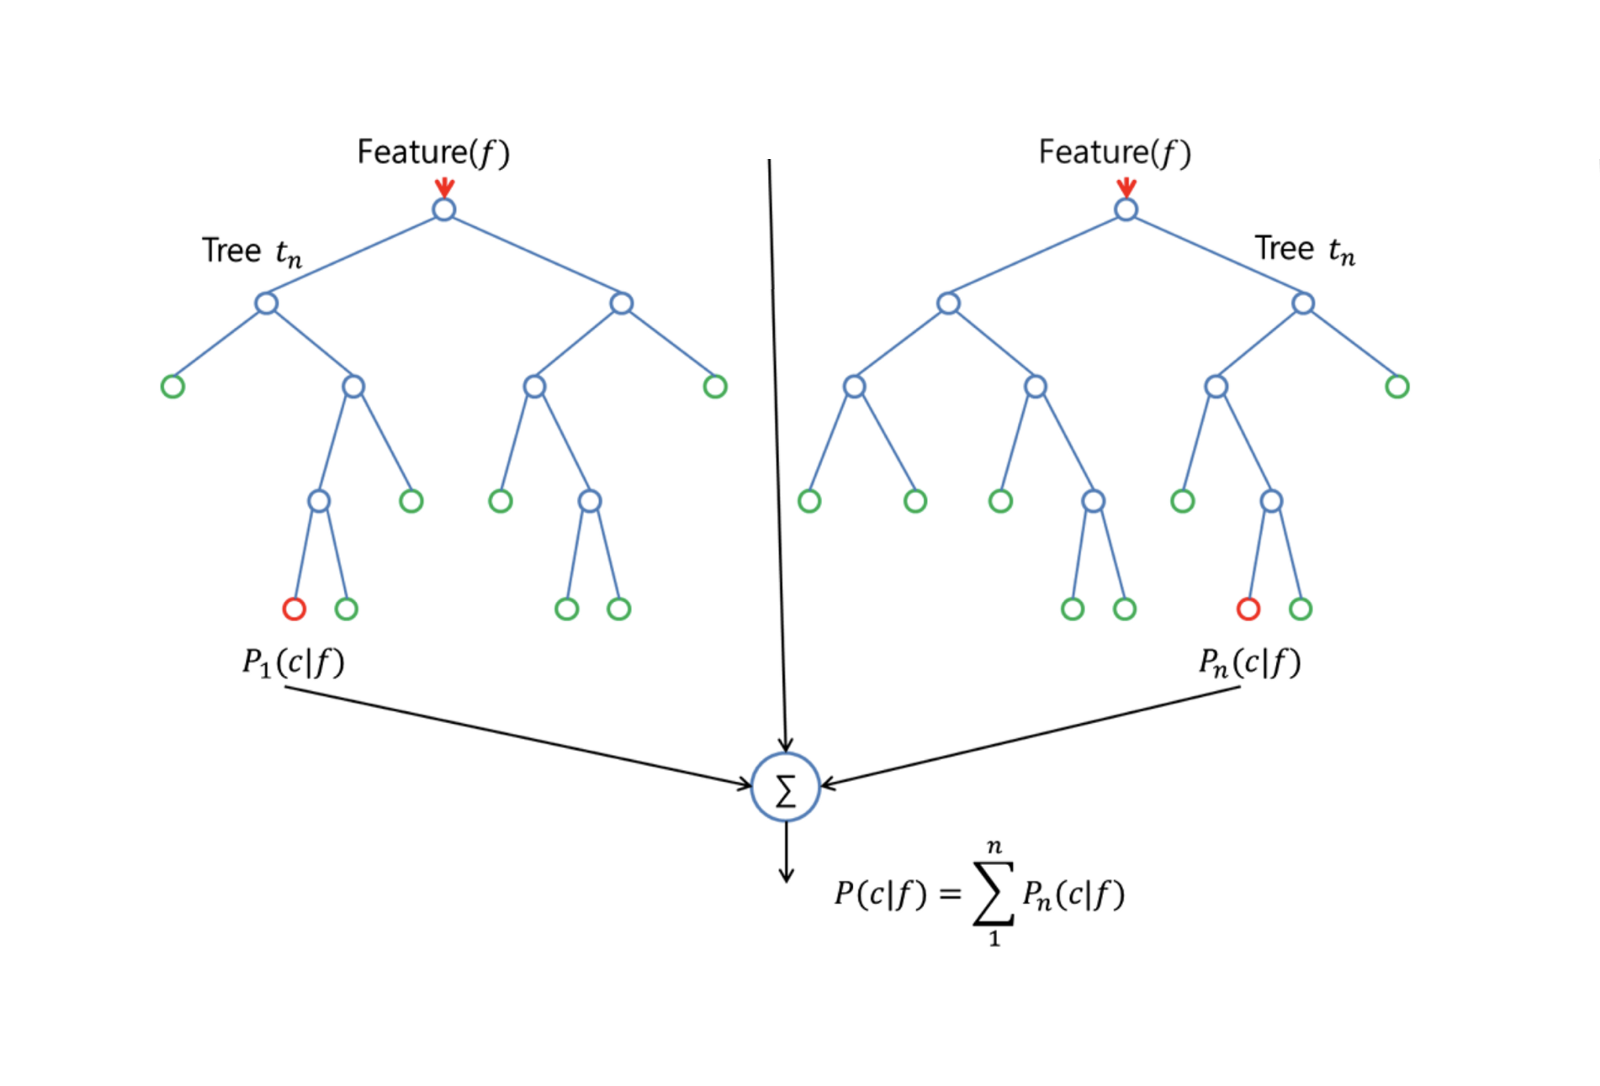

### RMSLE (Root Mean Squared Logarithmic Error)

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as
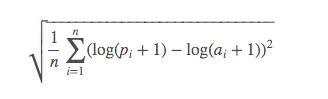
Where:
```
n is the number of hours in the test set
pi is your predicted count
ai is the actual count
log(x) is the natural logarithm
```
* License: RMSLE comes form kaggle website. https://www.kaggle.com/c/bike-sharing-demand#evaluation

In [24]:
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

**get the train dataset from the combine data `df`**

In [25]:
def get_data():
    data = df[df['dataset'] == 'train'].copy()
#     print data
    return data

**split train set and validation set with day. Normally, the trainset is from the first day to 19th day. Set the train set when before 15th day, and the validation set between 15th day and 19th day.**

In [26]:
def train_test_split(data, cutoff_day=15.0):
    train = data[data['day'] <= cutoff_day]
#     print train
    test = data[data['day'] > cutoff_day]
    return train, test

**prepare the input tand target feature**

In [27]:
def prep_data(data, input_cols):
    X = data[input_cols].as_matrix()
    
    y_registered = data['registered_log'].as_matrix()
    y_casual = data['casual_log'].as_matrix()
    y_count = data['count_log'].as_matrix()
#     print y_registered
    return X, y_registered, y_casual,y_count

**for validation set, there will be two target feature to be validated.**
1. count directly. 
2. total = casual + registered

after set the model and input cols, using model.fit() to get the model_registered, model_casual, model_count and then predict the values: y_pred_count, y_pred_total using model.predict().

Remeber to set the values smaller than 0 to 0. 

Then, using get_rmsle(predict, actual) method to get the RMSLE result. The smaller, the better.

In [28]:
def predict_on_validation_set(model, input_cols):
    data = get_data()

    train, test = train_test_split(data)

    X_train, y_train_registered, y_train_casual, y_train_count = prep_data(train, input_cols)
    X_test, y_test_registered, y_test_casual, y_test_count = prep_data(test, input_cols)
#     print X_test
    # for registered
    model_registered = model.fit(X_train, y_train_registered)
    y_pred_registered = np.exp(model_registered.predict(X_test)) - 1
    
    # for casual
    model_casual = model.fit(X_train, y_train_casual)
    y_pred_casual = np.exp(model_casual.predict(X_test)) - 1
    
    # for count directly
    model_count = model.fit(X_train, y_train_count)
    y_pred_count = np.exp(model_count.predict(X_test)) - 1
    
    # for count = registered + casual
    y_pred_total = np.round(y_pred_registered + y_pred_casual)
    y_pred_total[y_pred_total < 0] = 0

    y_test_count = np.exp(y_test_count) - 1
    y_test_total = np.exp(y_test_registered) + np.exp(y_test_casual) - 2
    
    score1 = get_rmsle(y_pred_count, y_test_count)
    score2 = get_rmsle(y_pred_total, y_test_total)
    return (y_pred_count, y_test_count, score1, y_pred_total, y_test_total, score2)

**Get the test dataset**

In [29]:
test_set = df[df['dataset'] == 'test'].copy()

**After building model, using model.predict() to predict the test dataset**

In [30]:
# predict on test set & transform output back from log scale
def predict_on_test_set(model, x_cols):
    # prepare training set
    train_set = df[df['dataset'] == 'train'].copy()
    X_train = df_train[x_cols].as_matrix()
    y_train_cas = train_set['casual_log'].as_matrix()
    y_train_reg = train_set['registered_log'].as_matrix()
    y_train_cnt = train_set['count_log'].as_matrix()

    # prepare test set
    X_test = test_set[x_cols].as_matrix()

    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    
    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    
    count_model = model.fit(X_train, y_train_cnt)
    y_pred_cnt = count_model.predict(X_test)
    y_pred_cnt = np.exp(y_pred_cnt) - 1
    # 1. count
    # 2. add casual & registered predictions together
    return y_pred_cnt, y_pred_reg + y_pred_cas

## 1. RandomForestRegressor

**Random Forest learning algorithm for regression. It supports both continuous and categorical features.**

### Parameters:

**n_estimators :** 

integer, optional (default=10)

The number of trees in the forest.


**max_depth :**

integer or None, optional (default=None)

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split :**

int, float, optional (default=2)

The minimum number of samples required to split an internal node:

If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a percentage and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

**min_samples_leaf : **

int, float, optional (default=1)

The minimum number of samples required to be at a leaf node:

If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

**n_jobs :**

integer, optional (default=1)

The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.

  * the explain comes from http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


**The text and code in the document by The scikit contributions is licensed under the 3-Clause BSD:**
scikit-learn is a Python module for machine learning built on top of SciPy and distributed under the 3-Clause BSD license.

The project was started in 2007 by David Cournapeau as a Google Summer of Code project, and since then many volunteers have contributed. See the AUTHORS.rst file for a complete list of contributors.

It is currently maintained by a team of volunteers.

Website: http://scikit-learn.org

**Get the result of validation set**

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'day', 'month', 'ideal','peak', 'DOW','sticky'
    ]

(rf_p_count, rf_t_count, rf_score1, rf_p_total, rf_t_total, rf_score2) = predict_on_validation_set(rf_model, rf_cols)
print 'count = ' + str(rf_score1) + ' , total = '+ str(rf_score2)

count = 0.44353268319380657 , total = 0.44125110350369806


**Get the correlation of input features**

In [32]:
df[rf_cols].corr()

,weather,temp,atemp,windspeed,workingday,season,holiday,sticky,hour,day,month,ideal,peak,DOW,sticky
weather,1.000000,-0.107789,-0.111544,0.041872,0.044963,-0.011501,0.008763,0.248225,-0.022471,0.008163,0.005275,-0.078386,0.002180,-0.052096,0.248225
temp,-0.107789,1.000000,0.987806,-0.025226,0.057064,0.317391,-0.034502,-0.018377,0.140565,0.022104,0.209409,0.367535,0.098168,-0.030126,-0.018377
atemp,-0.111544,0.987806,1.000000,-0.064800,0.055862,0.324754,-0.037571,-0.006529,0.136463,0.015913,0.215998,0.361609,0.093011,-0.032428,-0.006529
windspeed,0.041872,-0.025226,-0.064800,1.000000,-0.007068,-0.144799,-0.004601,-0.185587,0.135325,0.018631,-0.132233,-0.089405,0.128549,0.000282,-0.185587
workingday,0.044963,0.057064,0.055862,-0.007068,1.000000,0.003368,-0.233644,0.537624,-0.000201,0.003859,-0.016177,0.009109,-0.143955,-0.707051,0.537624
season,-0.011501,0.317391,0.324754,-0.144799,0.003368,1.000000,0.007127,0.088996,-0.005030,-0.000695,0.831440,0.088876,-0.001592,-0.007993,0.088996
holiday,0.008763,-0.034502,-0.037571,-0.004601,-0.233644,0.007127,1.000000,-0.114282,0.003009,-0.002654,0.040795,-0.007477,0.031757,-0.173926,-0.114282
sticky,0.248225,-0.018377,-0.006529,-0.185587,0.537624,0.088996,-0.114282,1.000000,-0.186976,0.048370,0.097536,0.004857,-0.155035,-0.407644,1.000000
hour,-0.022471,0.140565,0.136463,0.135325,-0.000201,-0.005030,0.003009,-0.186976,1.000000,0.000637,-0.005216,0.053056,0.174206,0.000327,-0.186976
day,0.008163,0.022104,0.015913,0.018631,0.003859,-0.000695,-0.002654,0.048370,0.000637,1.000000,0.009329,-0.005618,0.002618,-0.009955,0.048370


**Show the graph with predict values and valid values**

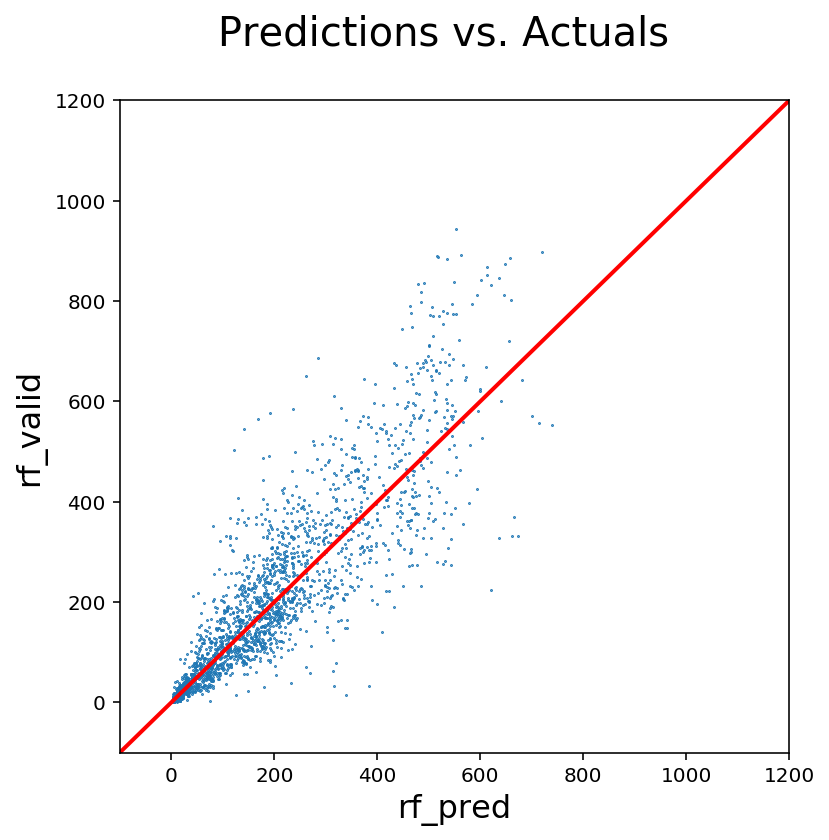

In [33]:
# Random Forest's predictions vs. actuals
plt.figure(figsize = (6,6))
plt.scatter(rf_p_count, rf_t_count, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200],[-100, 1200], color ='r', linestyle = '-', linewidth = 2)
plt.suptitle('Predictions vs. Actuals', fontsize = 20)
plt.xlabel('rf_pred',fontsize = 16)
plt.ylabel('rf_valid',fontsize = 16)
plt.show()

**Export the prediction into CSV**

In [34]:
rf_pred = predict_on_test_set(rf_model, rf_cols)
y_pred = np.round(rf_pred[1])
# output predictions for submission
test_set['count'] = y_pred
test_set.to_csv('submission1.csv', index=False)

**Result Analysis:**
1. I tried to use different input features and get different values. Here I just give a better one. If want, just change the rf_cols values.
2. with the rmlse result: count = 0.44353268319380657 , total = 0.44125110350369806; it is clear that using the total number which is add registered and causal is better than predict count directly.

## 2. GradientBoostingRegressor

**GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.**

### parameters

**loss :**

{‘ls’, ‘lad’, ‘huber’, ‘quantile’}, optional (default=’ls’)

loss function to be optimized. ‘ls’ refers to least squares regression. ‘lad’ (least absolute deviation) is a highly robust loss function solely based on order information of the input variables. ‘huber’ is a combination of the two. ‘quantile’ allows quantile regression (use alpha to specify the quantile).

**n_estimators :**

int (default=100)

The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

**learning_rate :** 

float, optional (default=0.1)

learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
  * the explain comes from http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

**max_depth :** 

integer, optional (default=3)

maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

**min_samples_leaf :**

int, float, optional (default=1)

The minimum number of samples required to be at a leaf node:

If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

**The text and code in the document by The scikit contributions is licensed under the 3-Clause BSD:**
scikit-learn is a Python module for machine learning built on top of SciPy and distributed under the 3-Clause BSD license.

The project was started in 2007 by David Cournapeau as a Google Summer of Code project, and since then many volunteers have contributed. See the AUTHORS.rst file for a complete list of contributors.

It is currently maintained by a team of volunteers.

Website: http://scikit-learn.org

In [35]:
params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
gbm_model = GradientBoostingRegressor(**params)
gbm_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'DOW', 'year', 'ideal', 'peak', 'sticky'
]

(gbm_p_count, gbm_t_count, gbm_score1, gbm_p_total, gbm_t_total, gbm_score2) = predict_on_validation_set(gbm_model, gbm_cols)
print 'count = ' + str(gbm_score1) + ' , total = '+ str(gbm_score2)

count = 0.315007370141069 , total = 0.3147256174226919


**Get the correlation of input features**

In [36]:
df[gbm_cols].corr()

,weather,temp,atemp,humidity,windspeed,holiday,workingday,season,hour,DOW,year,ideal,peak,sticky
weather,1.000000,-0.107789,-0.111544,0.422054,0.041872,0.008763,0.044963,-0.011501,-0.022471,-0.052096,-0.019551,-0.078386,0.002180,0.248225
temp,-0.107789,1.000000,0.987806,-0.073318,-0.025226,-0.034502,0.057064,0.317391,0.140565,-0.030126,0.045827,0.367535,0.098168,-0.018377
atemp,-0.111544,0.987806,1.000000,-0.055858,-0.064800,-0.037571,0.055862,0.324754,0.136463,-0.032428,0.044518,0.361609,0.093011,-0.006529
humidity,0.422054,-0.073318,-0.055858,1.000000,-0.278874,0.003560,0.016415,0.149133,-0.275486,-0.038581,-0.083866,-0.015879,-0.209539,0.596380
windspeed,0.041872,-0.025226,-0.064800,-0.278874,1.000000,-0.004601,-0.007068,-0.144799,0.135325,0.000282,-0.010293,-0.089405,0.128549,-0.185587
holiday,0.008763,-0.034502,-0.037571,0.003560,-0.004601,1.000000,-0.233644,0.007127,0.003009,-0.173926,0.020162,-0.007477,0.031757,-0.114282
workingday,0.044963,0.057064,0.055862,0.016415,-0.007068,-0.233644,1.000000,0.003368,-0.000201,-0.707051,-0.000907,0.009109,-0.143955,0.537624
season,-0.011501,0.317391,0.324754,0.149133,-0.144799,0.007127,0.003368,1.000000,-0.005030,-0.007993,-0.001844,0.088876,-0.001592,0.088996
hour,-0.022471,0.140565,0.136463,-0.275486,0.135325,0.003009,-0.000201,-0.005030,1.000000,0.000327,-0.003861,0.053056,0.174206,-0.186976
DOW,-0.052096,-0.030126,-0.032428,-0.038581,0.000282,-0.173926,-0.707051,-0.007993,0.000327,1.000000,-0.001368,-0.001616,0.102553,-0.407644


**Show the graph with predict values and valid values**

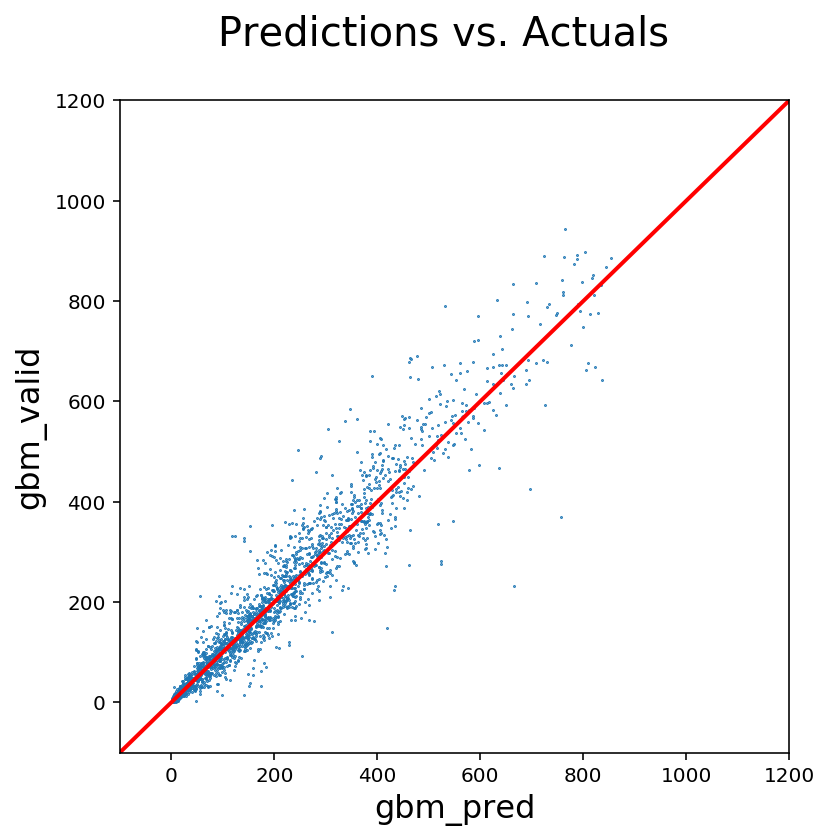

In [37]:
# Random Forest's predictions vs. actuals
plt.figure(figsize = (6,6))
plt.scatter(gbm_p_count, gbm_t_count, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200],[-100, 1200], color ='r', linestyle = '-', linewidth = 2)
plt.suptitle('Predictions vs. Actuals', fontsize = 20)
plt.xlabel('gbm_pred',fontsize = 16)
plt.ylabel('gbm_valid',fontsize = 16)
plt.show()

**Export the prediction into CSV**

In [38]:
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
y_pred = np.round(gbm_pred[1])
# output predictions for submission
test_set['count'] = y_pred
test_set.to_csv('submission2.csv', index=False)

**Result Analysis:**
1. I tried to use different input features and get different values. Here I just give a better one. If want, just change the gbm_cols values.
2. with the rmlse result: count = 0.315007370141069 , total = 0.3147256174226919; it is clear that using the total number which is add registered and causal is better than predict count directly.
3. GradientBoostingRegressor is better than RandomForestRegressor for bike sharing dataset.

## Sequential Model with LSTM Layers
## 1. Preparation before Model build:
### 1.1 Keras Perpare:
### backend engines - TensorFlow, Theano, or CNTK

Keras is a model-level library, providing high-level building blocks for developing deep learning models. It does not handle itself low-level operations such as tensor products, convolutions and so on. Instead, it relies on a specialized, well-optimized tensor manipulation library to do so, serving as the "backend engine" of Keras. Rather than picking one single tensor library and making the implementation of Keras tied to that library, Keras handles the problem in a modular way, and several different backend engines can be plugged seamlessly into Keras.

Here using the TensorFlow backend. (TensorFlow is an open-source symbolic tensor manipulation framework developed by Google. By default, Keras will use TensorFlow as its tensor manipulation library.)
```
pip install keras
pip install TensorFlow
pip install h5py (saving Keras models to disk).
```
### 1.2 Data Perpare:
1. get the train feature and target from train dataset.
2. scaling datas
3. split train dataset to train and validation data.
4. Generate dummy training data

**Delete the unuseful variables, get the feature `df_train_train` and target `df_test_train`.**

In [39]:
df = df.drop(['casual','registered','count','casual_log', 'registered_log', 'count_log','count_season', 'count_weather','dataset'], axis = 1)
df_train_train = df_train.drop(['datetime','casual','registered','count','dataset'], axis = 1)
df_test_train = df_train['count']

In [40]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour,year,DOW,peak,ideal,sticky
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,1.0,1.0,0.0,2011.0,5,0,0,0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,1.0,1.0,1.0,2011.0,5,0,0,0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,1.0,1.0,2.0,2011.0,5,0,0,0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,1.0,1.0,3.0,2011.0,5,0,0,0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,1.0,1.0,4.0,2011.0,5,0,0,0


**Scaling Variables**

To make training the network easier, standardize each of the continuous variables. Now shift and scale the variables such that they have zero mean and a standard deviation of 1.

reshape(): Gives a new shape to an array without changing its data.

In [41]:
# Scaling variables
scaler = StandardScaler()
scaler.fit(df_test_train.values.astype('float32').reshape(-1,1))
scalerx = StandardScaler()
scalerx.fit(df_train_train.values.astype('float32'))
df = df.apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour,year,DOW,peak,ideal,sticky
2011-01-01 00:00:00,-1.348213,-0.18175,-1.469481,-0.669887,-1.320196,-1.078501,0.940609,-1.553872,-1.600161,-1.674066,-1.665259,-1.001369,0.99693,-0.511304,-0.318522,-0.790028
2011-01-01 01:00:00,-1.348213,-0.18175,-1.469481,-0.669887,-1.423723,-1.166609,0.888805,-1.553872,-1.600161,-1.674066,-1.520617,-1.001369,0.99693,-0.511304,-0.318522,-0.790028
2011-01-01 02:00:00,-1.348213,-0.18175,-1.469481,-0.669887,-1.423723,-1.166609,0.888805,-1.553872,-1.600161,-1.674066,-1.375975,-1.001369,0.99693,-0.511304,-0.318522,-0.790028
2011-01-01 03:00:00,-1.348213,-0.18175,-1.469481,-0.669887,-1.320196,-1.078501,0.629785,-1.553872,-1.600161,-1.674066,-1.231334,-1.001369,0.99693,-0.511304,-0.318522,-0.790028
2011-01-01 04:00:00,-1.348213,-0.18175,-1.469481,-0.669887,-1.320196,-1.078501,0.629785,-1.553872,-1.600161,-1.674066,-1.086692,-1.001369,0.99693,-0.511304,-0.318522,-0.790028


**Splitting the data into training, and validation sets**

Split the data into two sets, one for training and one for validating as the network is being trained. 

Train on 10311 samples, validate on 575 samples: choose the datas when at the first day per month as validation dataset.


In [42]:
def preprocess_nn(datax, datay):
    indexx = pd.DatetimeIndex(datax['datetime']).day 
    testindex = indexx == 1
    datax[datax.drop('datetime',axis=1).columns] = datax[datax.drop('datetime',axis=1).columns].apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
    datay[datay.drop('datetime',axis=1).columns] = scaler.transform(datay[datay.drop('datetime',axis=1).columns])
    train_x = datax[~testindex]
    train_y = datay[~testindex]
    test_x = datax[testindex]
    test_y = datay[testindex]
    return train_x, train_y, test_x, test_y

In [43]:
datax = df_train.drop(['casual','registered','count','dataset'], axis = 1)
datay = df_train[['datetime','count']]
pre1 = preprocess_nn(datax,datay)

**Generate dummy training data**

In [44]:
import datetime 
timesteps =1
def preshape_nn(data_set, look_back = timesteps):
    out1= []
    for val in range(len(data_set) - look_back + 1):
        end1 = datetime.datetime.strptime(data_set['datetime'].values[look_back - 1 + val],"%Y-%m-%d %H:%M:%S" )
        timesteps_array = []
        for it in range(look_back): 
            timesteps_array.append(np.datetime64(end1))
            end1 = end1 - datetime.timedelta(hours = 1)
        timesteps_array = timesteps_array[::-1]
        timestep_unit = df.loc[timesteps_array].values.astype('float32')
        out1.append(timestep_unit)
    datax = np.stack(out1, axis=0)
    return datax

def preshape_nn_y(data_set, look_back = timesteps ):
    return data_set.drop('datetime',axis = 1).values[look_back - 1:]


## 2. Model Explain:
  * `example:` https://keras.io/getting-started/sequential-model-guide/

###  2.1 Sequential Model:
The type of this model is the Sequential model, a linear stack of layers. The first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. 
```
from keras.models import Sequential
model = Sequential()
```
### 2.2 Stack Layers (Using .add() ):
#### Layers:
`example`:
```
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))

core layer: Dense - regular densely-connected NN layer.
Recurrent Layer: LSTM - Long Short-Term Memory layer.
```

#### Activations:
```
Activations can either be used through an Activation layer, or through the activation argument supported by all forward layers.

Available activations:
softmax, elu, selu, softplus, softsign, relu, tanh, sigmoid, hard_sigmoid, linear
```

### 2.3 Configure Learning Process (Using .compile()):
`example`:
```
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:
    * An optimizer. This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. See: optimizers.
    * A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: losses.
    * A list of metrics. For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.
```

#### Loss Functions:
```
The actual optimized objective is the mean of the output array across all datapoints.

Available loss functions: 
mean_squared_error, mean_absolute_error,  mean_absolute_percentage_error, mean_squared_logarithmic_error, squared_hinge, hinge, categorical_hinge, logcosh
```

#### Optimizers:
```
SGD, RMSprop(This optimizer is usually a good choice for recurrent neural networks), Adagrad, Adadelta, Adam, Adamax, Nadam, TFOptimizer
```

### 2.4 Training Data (Using .fit()):
`example`:
```
model.fit(x_train, y_train, epochs=5, batch_size=32)
Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the fit function.
```
#### callbacks:
```
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

BaseLogger, TerminateOnNaN, ProgbarLogger, History, ModelCheckpoint, EarlyStopping, RemoteMonitor, LearningRateScheduler, TensorBoard (TensorBoard is a visualization tool provided with TensorFlow), ReduceLROnPlateau, CSVLogger, LambdaCallback
```

* all the explaintation comes form keras documentation. https://keras.io/

**The text and code in the document by The Keras contributions is licensed under the MIT:**

https://github.com/keras-team/keras/blob/master/LICENSE

https://opensource.org/licenses/MIT

In [45]:
from keras.callbacks import TensorBoard
def learn_nn(train_x, train_y, test_x, test_y, string):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, LSTMCell
    import numpy as np    

    data_dim = train_x.shape[-1] -1
    print data_dim
    # expected input data shape: (batch_size, timesteps, data_dim)
    
    # Here is the Sequential model:
    model = Sequential()
    
    #  Stacking layers is as easy as .add():


    #  Specifying the input shape
    #Stacked LSTM
    # returns a sequence of vectors of dimension 512
    model.add(LSTM(512, return_sequences=True,
                   input_shape=(timesteps, data_dim)))
    # returns a sequence of vectors of dimension 256
    model.add(LSTM(256, return_sequences=True))
    # returns a sequence of vectors of dimension 128
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(LSTM(8, return_sequences=True)) 
    model.add(LSTM(4, return_sequences=True))
    model.add(LSTM(2))  
    model.add(Dense(1, activation='linear')) 


    #####
    # Once model looks good, configure its learning process with .compile():
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop')
    
    # Generate dummy training data
    x_train = preshape_nn(train_x)
    y_train  = preshape_nn_y(train_y) 

    # Generate dummy validation data
    x_val = preshape_nn(test_x)
    y_val = preshape_nn_y(test_y)#scaler.transform(test_y)
    
    # generate dummy validation data
    now = datetime.datetime.now()
    print now.strftime("%Y%m%d-%H%M%S")
    
    # iterate on training data in batches:
    model.fit(x_train, y_train,batch_size=100,epochs=100, verbose = 1,
              validation_data=(x_val, y_val),
              callbacks=[TensorBoard(log_dir='logs1/' + now.strftime("%Y%m%d-%H%M%S") + string + "/")])
    model.save("models/" + now.strftime("%Y%m%d-%H%M%S") + ".h5")
    return model

Using TensorFlow backend.


### 2.5 Evaluate your performance:

### evaluation: RMSLE (Root Mean Squared Logarithmic Error)

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as
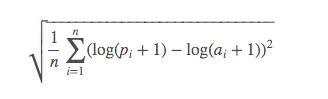
Where:
```
n is the number of hours in the test set
pi is your predicted count
ai is the actual count
log(x) is the natural logarithm
```
* RMSLE comes form kaggle website. https://www.kaggle.com/c/bike-sharing-demand#evaluation

In [46]:
# evaluation: RMSLE (Root Mean Squared Logarithmic Error)
def model_eval_nn(model, prepro):
    trainScore = math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[0]))), scaler.inverse_transform(preshape_nn_y(prepro[1]))))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore =  math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))), scaler.inverse_transform(preshape_nn_y(prepro[3]))))
    print('Test Score: %.2f RMSE' % (testScore)) 
    plt.plot(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))).reshape(-1,1) - scaler.inverse_transform(preshape_nn_y(prepro[3])).reshape(-1,1),'.')
def get_rmsle(model, prepro):
    diff = pd.DataFrame(np.log(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))).astype('float32') + 1) - np.log(scaler.inverse_transform(preshape_nn_y(prepro[3])).astype('float32') + 1))
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error).values[0]

### 2.6 Get The Result of RMSLE and Improve Model

Back to the third step - model build, change the layers, Loss Functions,Optimizers, callbacks and so on to improve the model until get the best result. The less RMSLE is, the better the model build.

16
20180420-200101
Instructions for updating:
Use the retry module or similar alternatives.
Train on 10311 samples, validate on 575 samples
Epoch 1/100
10311/10311 [==============================] - 15s 2ms/step - loss: 1.0064 - val_loss: 0.8883
Epoch 2/100
10311/10311 [==============================] - 10s 1ms/step - loss: 0.9884 - val_loss: 0.8409
Epoch 3/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.9011 - val_loss: 0.7389
Epoch 4/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.7688 - val_loss: 0.6176
Epoch 5/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.6441 - val_loss: 0.5109
Epoch 6/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.5393 - val_loss: 0.4415
Epoch 7/100
10311/10311 [==============================] - 15s 1ms/step - loss: 0.4437 - val_loss: 0.3802
Epoch 8/100
10311/10311 [==============================] - 14s 1ms/step - loss: 0.3725 - val_loss: 0.3273
Epoch 9/100


10311/10311 [==============================] - 12s 1ms/step - loss: 0.0279 - val_loss: 0.1000
Epoch 74/100
10311/10311 [==============================] - 13s 1ms/step - loss: 0.0278 - val_loss: 0.1076
Epoch 75/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0271 - val_loss: 0.1458
Epoch 76/100
10311/10311 [==============================] - 13s 1ms/step - loss: 0.0269 - val_loss: 0.1330
Epoch 77/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0268 - val_loss: 0.1233
Epoch 78/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0261 - val_loss: 0.1123
Epoch 79/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0256 - val_loss: 0.0941
Epoch 80/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0255 - val_loss: 0.1022
Epoch 81/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.0247 - val_loss: 0.1161
Epoch 82/100
10311/10311 [========================

0.5116556

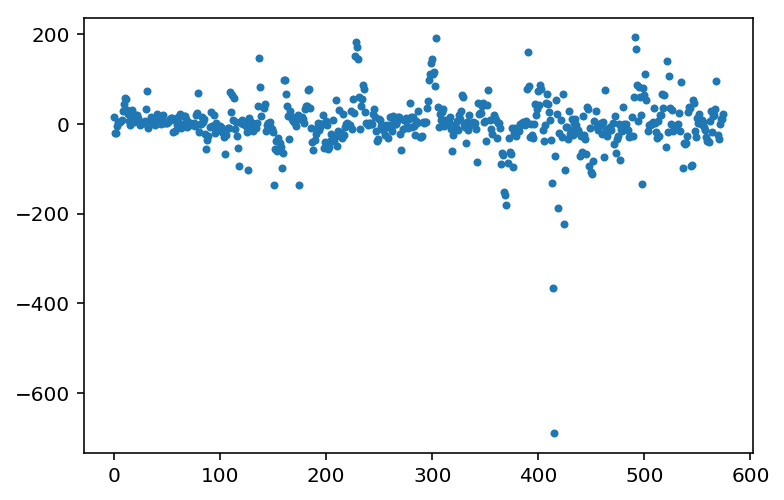

In [47]:
m1 = learn_nn(pre1[0],pre1[1],pre1[2],pre1[3],'MG')
model_eval_nn(m1,pre1)
get_rmsle(m1,pre1)

**Model Summary** 

In my model, I stack 9 LSTM layers on top of each other, making the model capable of learning higher-level temporal representations.

The first 8 LSTMs return the full output sequences, but the last one only returns the last step in its output sequence, thus dropping the temporal dimension (i.e. converting the input sequence into a single vector).


In [48]:
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 512)            1083392   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            787456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 16)             3136      
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 8)              800       
__________

### 2.7 Predict Test Data with Model

Get the test dataset, remeber scaler the dataset first, and then using model.predict() to predict the target values - `count`. Then, inverse scaler the target values and save it into excel. There are two ways to predict `count`. 
1. predict `count` and save values directly.
2. we can see `count = casual + registered` in train dataset. In this way, we can use model to predict `casual` and `registered` separately, and then add the two values together per row, the result should be the value of count. 
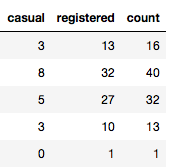

**Generate dummy training data**

In [49]:
def preshape_nn_test(data_set, look_back = timesteps):
    out1= []
    for val in range(len(data_set)):
        end1 = datetime.datetime.strptime(data_set['datetime'].values[val],"%Y-%m-%d %H:%M:%S" )
        timesteps_array = []
        for it in range(look_back): 
            timesteps_array.append(np.datetime64(end1))
            end1 = end1 - datetime.timedelta(hours = 1)
        timesteps_array = timesteps_array[::-1]
        timestep_unit = df.loc[timesteps_array].values.astype('float32')
        out1.append(timestep_unit)
    datax = np.stack(out1, axis=0)
    return datax

In [50]:
df_test_test = df_test.copy()
df_test_test[df_test_test.drop(['datetime','dataset'],axis=1).columns] = df_test_test[df_test_test.drop(['datetime','dataset'],axis=1).columns].apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
df_test_r = preshape_nn_test(df_test_test)

### 2.7.1 prdict count directly

Here the target count should be 0 or positive integer. After get the output, before save it into excel, remeber transfer the numbers into int, and if the values are smaller than 0, let them equal to 0.

In [51]:
pred = m1.predict(df_test_r)
out = scaler.inverse_transform(pred).astype(int)
out[out<=0] = 0
out = out[:,0]
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]
pred.to_csv("submission3.csv", index = False)

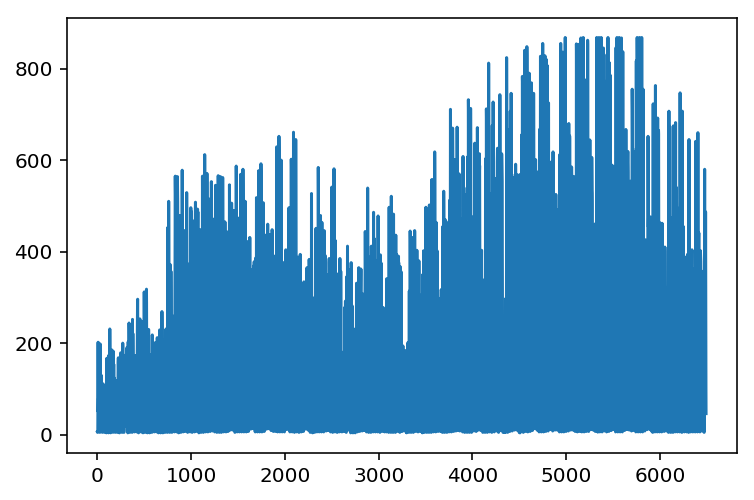

In [52]:
plt.plot(out)

**Calculates a Pearson correlation coefficient and the p-value for testing non-correlation.**

The Pearson correlation coefficient measures the linear relationship between two datasets. Strictly speaking, Pearson’s correlation requires that each dataset be normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

**The text in the document by The Scipy community is licensed under SciPy.org:
https://www.scipy.org/scipylib/license.html**

[0.98995385]


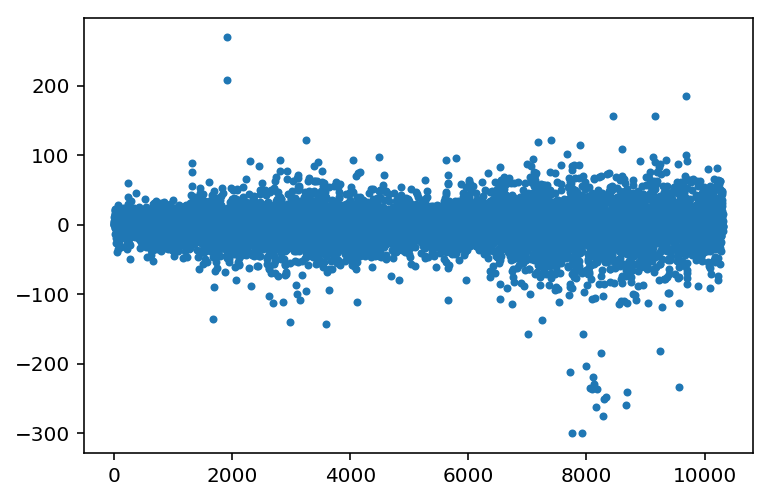

In [53]:
import scipy as scipy
plt.plot(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0])))-scaler.inverse_transform(preshape_nn_y(pre1[1])).reshape(-1,1),'.')
print scipy.stats.pearsonr(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0]))),scaler.inverse_transform(preshape_nn_y(pre1[1])).reshape(-1,1))[0]

### 2.7.2 predict casual and registered separately, and then add the two values together

**predict the casual number**

16
20180420-202212
Train on 10311 samples, validate on 575 samples
Epoch 1/100
10311/10311 [==============================] - 18s 2ms/step - loss: 0.5816 - val_loss: 0.3471
Epoch 2/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.1747 - val_loss: 0.0630
Epoch 3/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.0355 - val_loss: 0.0217
Epoch 4/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0207 - val_loss: 0.0200
Epoch 5/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0179 - val_loss: 0.0189
Epoch 6/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0161 - val_loss: 0.0174
Epoch 7/100
10311/10311 [==============================] - 13s 1ms/step - loss: 0.0145 - val_loss: 0.0185
Epoch 8/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.0126 - val_loss: 0.0172
Epoch 9/100
10311/10311 [==============================] - 13s 1ms/step - loss: 0.011

Epoch 77/100
10311/10311 [==============================] - 10s 997us/step - loss: 0.0029 - val_loss: 0.0142
Epoch 78/100
10311/10311 [==============================] - 10s 996us/step - loss: 0.0029 - val_loss: 0.0186
Epoch 79/100
10311/10311 [==============================] - 10s 994us/step - loss: 0.0028 - val_loss: 0.0148
Epoch 80/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.0028 - val_loss: 0.0186
Epoch 81/100
10311/10311 [==============================] - 10s 991us/step - loss: 0.0028 - val_loss: 0.0199
Epoch 82/100
10311/10311 [==============================] - 10s 991us/step - loss: 0.0026 - val_loss: 0.0188
Epoch 83/100
10311/10311 [==============================] - 10s 988us/step - loss: 0.0026 - val_loss: 0.0164
Epoch 84/100
10311/10311 [==============================] - 10s 987us/step - loss: 0.0026 - val_loss: 0.0181
Epoch 85/100
10311/10311 [==============================] - 10s 990us/step - loss: 0.0026 - val_loss: 0.0186
Epoch 86/100
10311/10

0.9029054

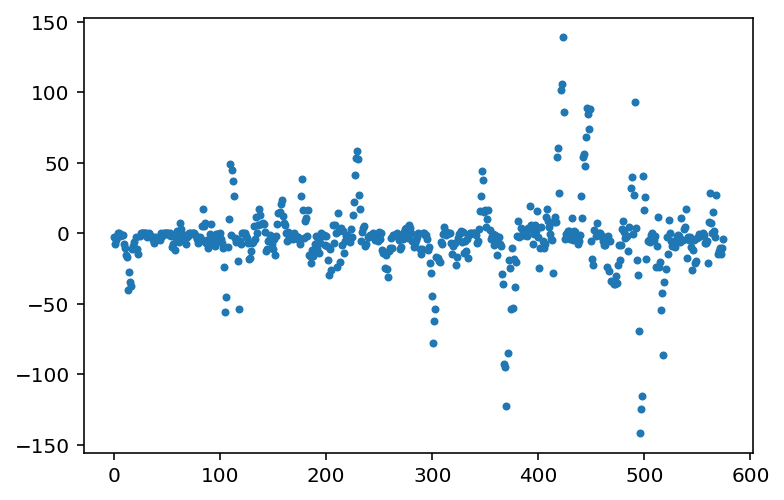

In [54]:
pre2 = preprocess_nn(df_train.drop(['casual','registered','count','dataset'], axis = 1),df_train[['datetime','casual']])
m2 = learn_nn(pre2[0],pre2[1],pre2[2],pre2[3],'MC')
model_eval_nn(m2,pre2)
get_rmsle(m2,pre2)

**predict the registered number**

16
20180420-204207
Train on 10311 samples, validate on 575 samples
Epoch 1/100
10311/10311 [==============================] - 19s 2ms/step - loss: 0.6919 - val_loss: 0.5925
Epoch 2/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.5797 - val_loss: 0.4867
Epoch 3/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.4760 - val_loss: 0.4051
Epoch 4/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.3872 - val_loss: 0.3226
Epoch 5/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.3217 - val_loss: 0.2802
Epoch 6/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.2783 - val_loss: 0.2446
Epoch 7/100
10311/10311 [==============================] - 12s 1ms/step - loss: 0.2389 - val_loss: 0.1996
Epoch 8/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.1954 - val_loss: 0.1545
Epoch 9/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.147

10311/10311 [==============================] - 12s 1ms/step - loss: 0.0177 - val_loss: 0.0635
Epoch 77/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.0184 - val_loss: 0.0774
Epoch 78/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.0175 - val_loss: 0.1049
Epoch 79/100
10311/10311 [==============================] - 11s 1ms/step - loss: 0.0169 - val_loss: 0.0873
Epoch 80/100
10311/10311 [==============================] - 10s 997us/step - loss: 0.0169 - val_loss: 0.0553
Epoch 81/100
10311/10311 [==============================] - 10s 1ms/step - loss: 0.0163 - val_loss: 0.0652
Epoch 82/100
10311/10311 [==============================] - 10s 1ms/step - loss: 0.0163 - val_loss: 0.0584
Epoch 83/100
10311/10311 [==============================] - 10s 1ms/step - loss: 0.0162 - val_loss: 0.0669
Epoch 84/100
10311/10311 [==============================] - 10s 1ms/step - loss: 0.0163 - val_loss: 0.0637
Epoch 85/100
10311/10311 [======================

0.5025434

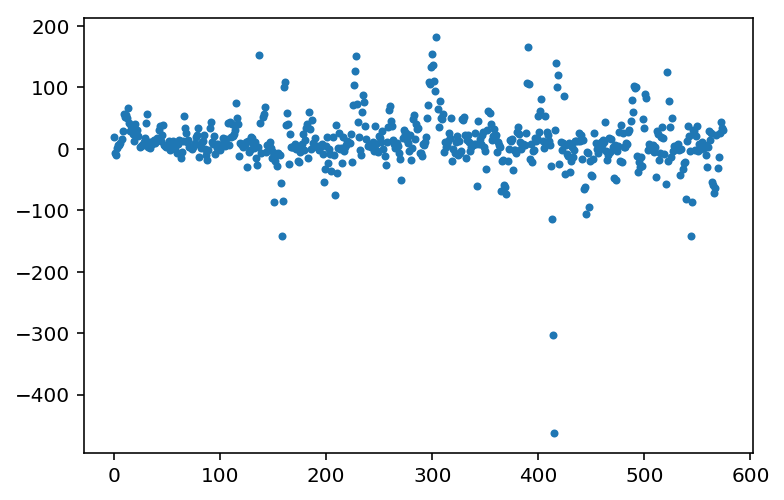

In [55]:
pre3 = preprocess_nn(df_train.drop(['casual','registered','count','dataset'], axis = 1),df_train[['datetime','registered']])
m3 = learn_nn(pre3[0],pre3[1],pre3[2],pre3[3],'MR')
model_eval_nn(m3,pre3)
get_rmsle(m3,pre3)

**Transfer the numbers into int, and if the values are smaller than 0, let them equal to 0.**

In [56]:
out2 = scaler.inverse_transform(m2.predict(preshape_nn_test(df_test))).astype(int)
out3 = scaler.inverse_transform(m3.predict(preshape_nn_test(df_test))).astype(int)
out2[out2<0] = 0
out3[out3<0] = 0

out2 = out2[:,0]
out3 = out3[:,0]


**Count = Casual + Registered**

In [57]:
outb = np.array(out2 + out3)
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': outb})
pred = pred[['datetime','count']]
pred.to_csv("submission4.csv", index = False)

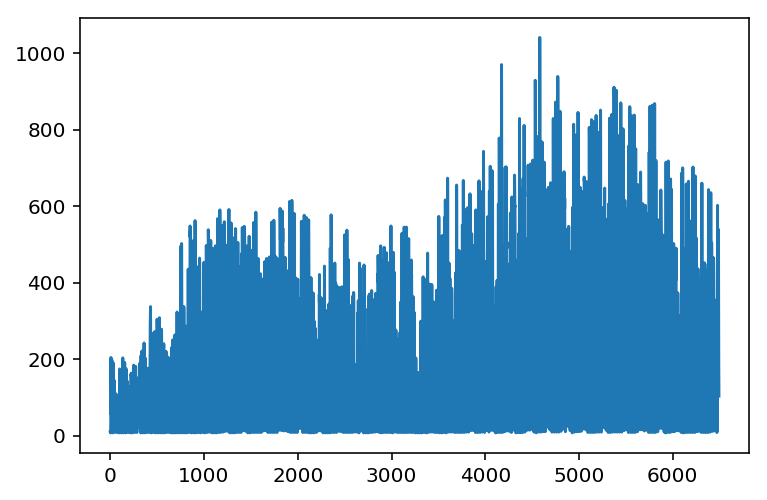

In [58]:
plt.plot(outb)

**Plot out versus outb as lines and/or markers.**

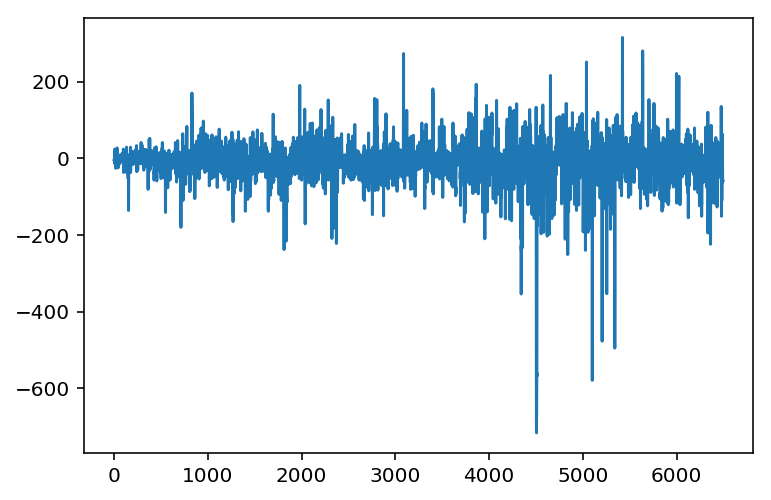

In [59]:
plt.plot(out-outb)

## 3. Result Analysis: 
1. I tried to use different active functions, loss functions and so on to get different values. Here I just give a better one.

2. with the rmlse result: count = 0.43323475, causal = 0.67320853, registered = 0.4203577; it is clear that using the LSTM is not better than RandomForest. But It is a final project, the propose is to learn how to using deep learning. As professor suggested, I used LSTM here.

#  Part 5 - Conclusion:
#### 1. It is clear that the engineered features provide more information for the regression models, allowing them to make better predictions, as is the case of the features rush hours, ideal temperature and humidity, along with the indicators for sticky weather.
#### 2. It is clear that predict count using registered and causal seprately is better than predict count directly.
#### 3. With the implemented solution it was clear that the better model is Random Forest, In this model, Gradient Boosting method is better.
     * Model Random Forest:
        * RandomForestRegressor:  count = 0.44353268319380657 , total = 0.44125110350369806
        * GradientBoostingRegressor: count = 0.315007370141069 , total = 0.3147256174226919
     * Model LSTM:
        count = 0.43323475, causal = 0.67320853, registered = 0.4203577

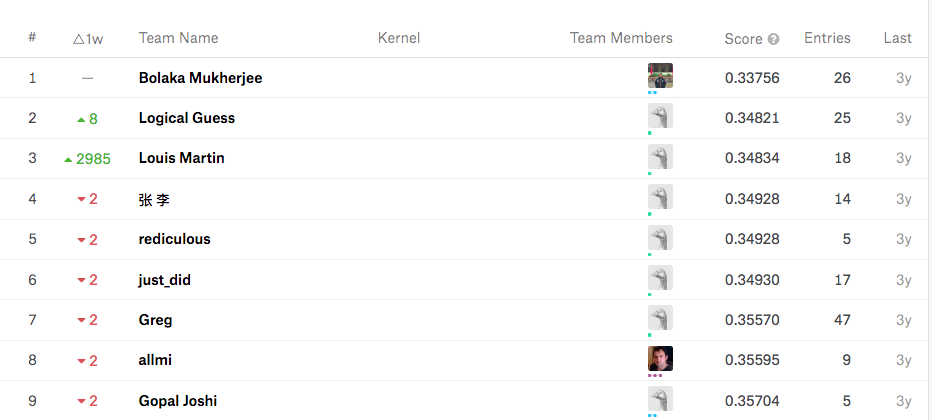

The code in the document by Github ST7oo is licensed under the MIT License: https://opensource.org/licenses/MIT